In [1]:
import pandas as pd

In [10]:
train_df = pd.read_csv('./data/res_df.csv')
test_df = pd.read_csv('./data/news_2024_긍정부정.csv')

In [11]:
# 긍정, 부정 확인

print('긍정 개수 : {}'.format(train_df['label'].value_counts()[1]))
print('부정 개수 : {}'.format(train_df['label'].value_counts()[0]))

긍정 개수 : 41327
부정 개수 : 202099


In [13]:
test_df = test_df[['party_content', 'party_name']]

test_df

,party_content,party_name
0,지상파·종편 여론조사서 접전 양상…오차 범위 내 동률도신당 포함시 민주 33% 국힘...,더불어민주당
1,지상파·종편 여론조사서 접전 양상…오차 범위 내 동률도신당 포함시 민주 33% 국힘...,국민의힘
2,지상파·종편 여론조사서 접전 양상…오차 범위 내 동률도신당 포함시 민주 33% 국힘...,새로운미래
3,1 뉴스1 ⓒ News1 민경석 기자(서울=뉴스1) 노선웅 기자 = 올해 4월10일...,더불어민주당
4,1 뉴스1 ⓒ News1 민경석 기자(서울=뉴스1) 노선웅 기자 = 올해 4월10일...,국민의힘
...,...,...
185259,"이 의원은 이날 뉴스1 통화에서 ""(무소속 출마도) 충분히 자신 있다""며 ""당선 후...",무소속
185260,앞서 국민의힘 공천관리위원회는 이날 이 의원 지역구인 울산 남갑을 비롯해 강남갑·을...,국민의힘
185261,"대구 동갑은 류성걸 의원, 대구 북갑은 국민의힘 의원 지역구다",국민의힘
185262,"이 의원은 이날 페이스북에도 ""오늘 국민의힘이 저를 버렸다""며 ""잠시 떠나더라도 승...",국민의힘


In [14]:
X_train = train_df['party_content']
y_train = train_df['label']

X_test = test_df['party_content']

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF를 사용하여 텍스트 데이터를 벡터 형태로 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test) 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size = 0.2, random_state = 42)

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

y_resampled.value_counts()

label
0    161648
1    161648
Name: count, dtype: int64

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),  # TF-IDF 변환
    ('clf', LogisticRegression())  # 로지스틱 회귀 분류기
])

pipeline.fit(X_resampled, y_resampled)

# validation 세트에 대한 예측 결과 가져오기
y_pred_val = pipeline.predict(X_val)

Validation Accuracy: 0.9556340631803804
Confusion Matrix:
[[38719  1732]
 [  428  7807]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     40451
           1       0.82      0.95      0.88      8235

    accuracy                           0.96     48686
   macro avg       0.90      0.95      0.93     48686
weighted avg       0.96      0.96      0.96     48686



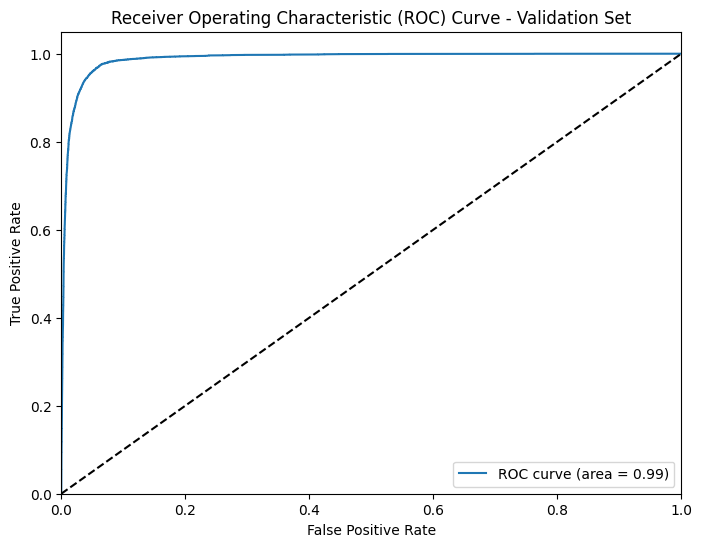

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 정확도 계산
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)

# 혼동 행렬(confusion matrix) 계산
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# 분류 보고서(classification report) 출력
class_report = classification_report(y_val, y_pred_val)
print("Classification Report:")
print(class_report)

# ROC 곡선 및 AUC 계산
y_pred_proba_val = pipeline.predict_proba(X_val)[:, 1]  # 양성 클래스에 대한 확률 추출
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_proba_val)
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 모델의 ROC 곡선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc="lower right")

In [22]:
pipeline.fit(X_resampled, y_resampled)

predicted_label = pipeline.predict(X_test_tfidf)

test_df['label'] = predicted_label

test_df['label'].value_counts()

label
0    148536
1     36728
Name: count, dtype: int64

In [23]:
test_df.to_csv('./data/2024결과.csv', index = False)